# Exercise 3 – Interpretation von Modellen

### Folgende Teilaufgaben beschreiben die Fragestellungen. Untersuchen Sie die Art der Variablen und die Verteilung der Zielvariablen. Gegebenenfalls ist eine Datenvorverarbeitung nötig. Nennen Sie die möglichen  Methoden.  Wählen  Sie  eine  Methode  aus  und  begründen  Sie  Ihre  Auswahl.  Bitte separieren  Sie  die  Datensätze  mit  80%  :  20%  =  Training  :  Test  und  führen  Sie  die  Methode  ohne Parameteroptimierung aus. Vergleichen Sie die Ergebnisse mit denen von vorgegebenen Methode(n).

### c) Welche Charakteristika eines weiblichen Krebses in `crabs.txt` finden männliche Krebs (sogenannte Satellites auf Englisch) anziehend? Schätzen Sie die Anzahl der männlichen Krebse in Test-Datensatz anhand der Charakteristika der weiblichen Krebse. Baseline: Poisson Regression.

### Importieren der Bibliotheken

In [145]:
# Common Libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Regression models
from module.poisson_regression import PoissonRegression
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression

# Evaluation
from sklearn.model_selection import cross_val_score, train_test_split  # cross validation

## Einlesen des Datensatzes

Die Daten werden mithilfe der Bibliothek Pandas aus der CSV-Datei gelesen. Die Spalten werden durch eine unterschiedliche Anzahl von Leerzeichen voneinander getrennt. Dies kann durch den Regulären Ausdruck "\s+" abgefangen werden. Die Namen der Variablen werden aus der Beschreibungsdatei übernommen. Der Identifier ist für die nachfolgende Analyse nicht von Relevanz und wird deswegen entfernt. Es handelt sich um eine fortlaufende, ganzzahlige Nummer um die Krebse voneinander unterscheiden zu können.

In [146]:
data = pd.read_csv('./data/crabs.txt', sep="\s+", header=None)  # whitespaces as seperators
data.columns = ["ID", "Color", "Spine", "Width", "Weight", "Sallite"]  # define column names
data = data.drop("ID",axis=1)

## Vertrautmachen mit den Daten

In [147]:
print(data.shape) # print the number of rows and columns
print(data.dtypes) # print the data types of the columns
data["Sallite"].count() # check if the number of male crabs is equal to the amount of female crabs

(173, 5)
Color        int64
Spine        int64
Width      float64
Weight     float64
Sallite      int64
dtype: object


173

Die Daten umfassen 173 weibliche Pfeilschwanzkrebse. Zu jedem Krebs wird die Helligkeit (`Color`), der Zustand des Rückens (`Spine`), die Breite des Panzers (`Width`), das Gewicht (`Weight`) sowie die Anzahl der männlichen Anhänger (`Sallite`) angegeben. Zu den 173 weiblichen Krebsen gibt es genau 173 männliche Anhänger.

- Anzahl der männlichen Anhänger (_Zielvariable_): Numerisch-Diskret (Natürliche Zahlen mit 0)
    - `Sallite`: Integer
    
Erkärende Variablen der Krabben:

- Helligkeit: Kategorisch-Ordinal
    - `Color`: Integer (1 = medium light, 2 = medium, 3 = medium dark, 4 = dark)

- Zustand des Rückens: Kategorisch-Ordinal
    - `Spine`: Integer (1 = both good, 2 = one worn or broken, 3 = both worn or broker)

- Gewicht in Kilogramm, Numerisch-Kontinuierlich
    - `Weight`: Float

- Breite des Panzers: Numerisch-Kontinuierlich
    - `Width`: Float

(Quelle der Einheiten und Rückenzustandsbeschreibung: https://rdrr.io/cran/rsq/man/hcrabs.html)

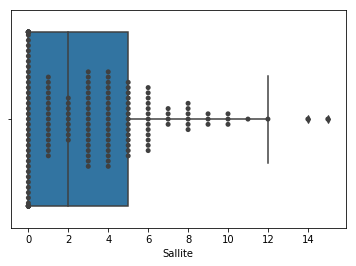

In [148]:
# print the boxplit of the sallite column with data points
ax = sns.boxplot(x="Sallite", data=data)
ax = sns.swarmplot(x="Sallite", data=data, color=".25")

Die meisten weiblichen Krabben haben nur wenige männliche Krabben als Anhänger. Es gibt wenige weibliche Kraben zu denen sich die männlichen Kraben besonders hingezogen fühlen.

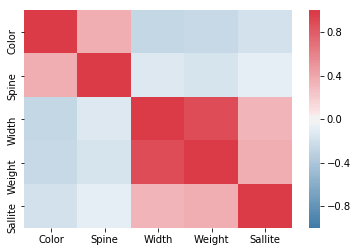

In [149]:
# Pearson Correlation
corr_pearson = data.corr('pearson')

cmap = sns.diverging_palette(240, 10, n=100)

sns.heatmap(corr_pearson, 
            xticklabels=corr_pearson.columns.values,
            yticklabels=corr_pearson.columns.values, cmap=cmap, vmin=-1, vmax=1);

Es lässt sich klar eine Korrelation zwischen der Breite und dem Gewicht der Krabben erkennen. Die meisten Krabben haben nur wenige Partner, wenige Krabben haben sehr viele, bis zu 15, Männchen. Die Anzahl der männlichen Anhänger korreliert nicht stark mit den anderen Variablen. Deswegen lässt sich zunächst nicht eindeutig klären, was männliche Krabben anziehend finden. Tendentiell scheint hellere Farben besser zu sein als dunkele und breite, schwere Krabben scheinen zu punkten.

Da es keine nominalen Variablen gibt, die es umzuwandeln gilt und keine Daten fehlen, wird nun begonnen die exogene Variable zu schätzen.

### Schätzen der Anzahl männlicher Krebse

In [150]:
X, y = data.values[:,:-1], data.values[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

Es handelt sich um ein Regressionsproblem bei dem die Anzahl der männlichen Krebse anhand der anderen Größen geschätzt werden muss. $y$ bezeichnet die tatsächliche Anzahl der männlichen Krebse. $X$ ist die Matrix mit allen anderen Größen. Dadurch, dass ein Regressionsproblem vorliegt kann man schon Klassifikatoren, Clustering-Algorithmen und Methoden zur Dimensionsreduktion für die Schätzung der männlichen Anhänger ausschließen. Im Folgenden wird auf den Trainingsteil die Poisson-Regression und andere unterschiedliche Modelle ausprobiert.

In [151]:
def eval(model, model_name, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores)
    return "{}: RMSE {}, VAR {}".format(model_name, scores.mean(), scores.var())

eval(PoissonRegression(),"Poisson",X_train, y_train)

Optimization terminated successfully.
         Current function value: 2.531548
         Iterations 10
Optimization terminated successfully.
         Current function value: 2.704732
         Iterations 10
Optimization terminated successfully.
         Current function value: 2.656779
         Iterations 10
Optimization terminated successfully.
         Current function value: 2.735276
         Iterations 8
Optimization terminated successfully.
         Current function value: 2.802714
         Iterations 10


'Poisson: RMSE 3.3037781985527106, VAR 0.3664161452758746'

Für die Poisson-Regression wurde eine Klasse erstellt die gemäß dem Adapter-Entwurfsmuster ermöglicht die Scikitlearn Crossvalidierung zu verwenden. Die Implementierung ist unter "./module/poisson_regression.py" zu finden. Sie basiert auf die Poisson-Regressionsimplementierung von dem Paket $statsmodels$. Der RSME ist mit dem Hintergrund, dass sehr viele Werte klein sind, relativ groß.

In [152]:
print(eval(Lasso(),"Lasso", X_train, y_train))
print(eval(ElasticNet(),"ElasticNet", X_train, y_train))
print(eval(SVR(kernel="rbf", gamma=0.1),"SVM RBF", X_train, y_train))
print(eval(SVR(kernel="linear"),"SVM Linear", X_train, y_train))
print(eval(LinearRegression(),"LinearRegression", X_train, y_train))

Lasso: RMSE 3.058601285404473, VAR 0.18443334730406824
ElasticNet: RMSE 3.0395706197313546, VAR 0.18441581598064283
SVM RBF: RMSE 3.148264945667124, VAR 0.3160513181113745
SVM Linear: RMSE 3.0606338333771737, VAR 0.34465169618605007
LinearRegression: RMSE 3.014501722341287, VAR 0.22486445430489604


Die lineare Regression schneidet auf den Trainingsdatensatz am besten ab. Deswegen wird nun diese Methode auf den Testdatensatz mit der Poissonregression verglichen.

In [153]:
linear = LinearRegression().fit(X_train, y_train)
linear.score(X_train, y_train)

0.14502946481162748

In [154]:
linear.score(X_test, y_test)

0.1495646716815906

In [155]:
poisson = PoissonRegression().fit(X_train, y_train)
poisson.score(X_train, y_train)

Optimization terminated successfully.
         Current function value: 2.699011
         Iterations 10


0.11299651410653078

In [156]:
poisson.score(X_test, y_test)

0.11844945306305034

Die Bestimmtheit des linearen Modells ist größer und damit besser als bei der Poisson-Regression. Es beschreibt besser die Daten. Die Bestimmtheit befindet sich allerdings auf einem sehr niedrigen Niveau.